<a href="https://colab.research.google.com/github/kimbyeolhee/Regrssion-study/blob/main/%EC%84%A0%ED%98%95_%ED%9A%8C%EA%B7%80%EB%AA%A8%EB%8D%B8%EC%9D%84_%EC%9C%84%ED%95%9C_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B3%80%ED%99%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Target : 반드시 정규분포를 가져야함. 이를 위해 주로 **로그변환**을 적용
* Feature : 
* 1. StandardScaler 클래스를 통해 평균이 0, 분산이 1인 표준 정규분포를 가진 데이터 세트로 변환하거나 MinMaxScaler 클래스를 이용해 최솟값이 0이고 최댓값이 1인 정규화를 수행
* 2. 스케일링/정규화를 수행한 데이터 세트에 다시 다항 특성을 적용하는 방법. 보통 1번 방법을 통해 예측 성능에 향상이 없을 경우 이와같은 방법 적용 (다항 변환으로 생성되는 피쳐의 개수가 기하급수적으로 늘어나서 과적합 이슈발생)
* 3. 원래 값에 **log**를 적용하면 보다 정규분포에 가까운 형태로 값이 분포 (제일 많이 사용되는 방법)


* 선형 회귀의 데이터 인코딩 : 주로 원-핫 인코딩 (0001, 0010, 0100) 
* (1,2,3 이렇게 아니고 값 자체의 상관도를 없애기 위해서)

(array([ 21.,  55.,  82., 154.,  84.,  41.,  30.,   8.,  10.,  21.]),
 array([ 5. ,  9.5, 14. , 18.5, 23. , 27.5, 32. , 36.5, 41. , 45.5, 50. ]),
 <a list of 10 Patch objects>)

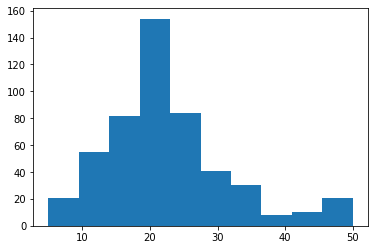

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

boston = load_boston()
bostonDF= pd.DataFrame(boston.data, columns = boston.feature_names)
bostonDF['PRICE'] = boston.target

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_data,y_target, test_size=0.3, random_state=156)

plt.hist(y_target, bins=10)

target 값은 정규분포 모양

In [2]:
## 데이터 변환 함수
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

# p_degree는 다항식 특성을 추가할 때 적용, 2 이상 부여하지 않음
def get_scaled_data(method='None', p_degree=None, input_data=None) :
  if method == 'Standard':
    scaled_data = StandardScaler().fit_transform(input_data)
  elif method == 'MinMax' :
    scaled_data = MinMaxScaler().fit_transform(input_data)
  elif method == 'Log':
    scaled_data = np.log1p(input_data)
  else:
    scaled_data = input_data
  
  if p_degree != None:
    scaled_data = PolynomialFeatures(degree=p_degree,
                                     include_bias=False).fit_transform(input_data)
                                
  return scaled_data

In [3]:
## 규제 선형회귀 모델 함수
from sklearn.linear_model import Lasso, ElasticNet,Ridge
from sklearn.model_selection import cross_val_score

def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, verbose=True):
  coeff_df = pd.DataFrame()
  if verbose : print('######', model_name , '######')
  for param in params:
    if model_name =='Ridge' : model = Ridge(alpha=param)
    elif model_name == 'Lasso': model = Lasso(alpha=param)
    elif model_name == 'ElasticNet': model = ElasticNet(alpha=param, l1_ratio=0.7)
    neg_mse_scores = cross_val_score(model, X_data_n, y_target_n, scoring="neg_mean_squared_error", cv=5)

    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0}일 때 5 fold의 평균 RMSE : {1: .3f}'.format(param,avg_rmse))

    model.fit(X_data,y_target)

    coeff = pd.Series(data=model.coef_ , index=X_data.columns)
    colname = 'alpha'+str(param)
    coeff_df[colname] = coeff
  return coeff_df

In [4]:
# Ridge의 alpha값을 다르게 적용한 RMSE값 추출
alphas = [0.1,1,10,100]

scale_methods = [(None,None),('Standard',None),('Standard',2),
                 ('MinMax',None),('MinMax',2),('Log',None)]
                
for scale_method in scale_methods:
  X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1],
                                  input_data=X_data)
  print('\n 변환유형: {0}, Polynomial degree:{1}'.format(scale_method[0],scale_method[1]))
  get_linear_reg_eval('Ridge', params=alphas, X_data_n = X_data_scaled,
                      y_target_n=y_target, verbose=False)


 변환유형: None, Polynomial degree:None
alpha 0.1일 때 5 fold의 평균 RMSE :  5.788
alpha 1일 때 5 fold의 평균 RMSE :  5.653
alpha 10일 때 5 fold의 평균 RMSE :  5.518
alpha 100일 때 5 fold의 평균 RMSE :  5.330

 변환유형: Standard, Polynomial degree:None
alpha 0.1일 때 5 fold의 평균 RMSE :  5.826
alpha 1일 때 5 fold의 평균 RMSE :  5.803
alpha 10일 때 5 fold의 평균 RMSE :  5.637
alpha 100일 때 5 fold의 평균 RMSE :  5.421

 변환유형: Standard, Polynomial degree:2
alpha 0.1일 때 5 fold의 평균 RMSE :  9.141
alpha 1일 때 5 fold의 평균 RMSE :  8.938
alpha 10일 때 5 fold의 평균 RMSE :  10.556
alpha 100일 때 5 fold의 평균 RMSE :  10.566

 변환유형: MinMax, Polynomial degree:None
alpha 0.1일 때 5 fold의 평균 RMSE :  5.764
alpha 1일 때 5 fold의 평균 RMSE :  5.465
alpha 10일 때 5 fold의 평균 RMSE :  5.754
alpha 100일 때 5 fold의 평균 RMSE :  7.635

 변환유형: MinMax, Polynomial degree:2
alpha 0.1일 때 5 fold의 평균 RMSE :  9.141
alpha 1일 때 5 fold의 평균 RMSE :  8.938
alpha 10일 때 5 fold의 평균 RMSE :  10.556
alpha 100일 때 5 fold의 평균 RMSE :  10.566

 변환유형: Log, Polynomial degree:None
alpha 0.1일 때 5 fold의 평균 